In [1]:
import os, sys
sys.path.append('/home/dcooper/git/Bridgeport')
from interactive.interactive_utils import *
from utils.utils import write_FASTA
from Bridgeport.Bridgeport import Bridgeport
import py3Dmol
from datetime import datetime
from rdkit.Chem.Draw import rdDepictor

/home/dcooper/anaconda3/envs/prep/lib/python3.12/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


**Let's start with some basic information...**

**Protein Input**

- *input_pdb_dir*: (str) path to directory where the *input_pdb* can be found. 
- *input_pdb*: (str) name of input structure
- *chain*: (str) of chain to use from *input_pdb* to align

**Ligand Input** (if you are doing an analogue, fill in this information for the templace ligand in your experimental structure)

- *name*: (str) a name for your ligand
- *resname*: (str) resname of ligand found in *input_pdb*. If the ligand, is a peptide set to "False".
- *chainid*: (str) if ligand is a peptide, specify the letter code that denotes the ligand, if not set to "False".
- *smiles*: (str) smiles string for you ligand. 

In [2]:
# Set you working directory
input_dir = '/home/dcooper/projects/B2A/'

In [3]:
# Protein input
input_pdb_dir = os.path.join(input_dir, 'input_pdb') # Change as needed
input_pdb = '7dhr.pdb' # Change as needed
chain = 'R' # Change as needed


# Ligand input
name = 'isoproterenol'
resname = '5FW'
chainid = False
lig_smiles = "CC(C)NCC(C1=CC(=C(C=C1)O)O)O"


In [4]:
# Build initial .json file and BP object
working_dir = '/home/dcooper/projects/B2A'
json_dict = {'working_dir': working_dir}

# Update params
json_dict['Protein'] = {'input_pdb_dir': input_pdb_dir,
                        'input_pdb': input_pdb,
                        'chain': chain}


json_dict['Ligand'] = {'name': name,
                       'resname': resname,
                       'chainid': chainid,
                       'smiles': lig_smiles}

json_fn = 'interactive.json'
write_json(json_dict, json_fn)
start = datetime.now()
BP = Bridgeport(json_fn, verbose=False)

06/17/2025 12:10:19//Welcome to Bridgeport.
06/17/2025 12:10:19//Found input parameters.
06/17/2025 12:10:19//working_dir:
06/17/2025 12:10:19//working_dir: /home/dcooper/projects/B2A
06/17/2025 12:10:19//Protein:
06/17/2025 12:10:19//	input_pdb_dir: /home/dcooper/projects/B2A/input_pdb
06/17/2025 12:10:19//	input_pdb: 7dhr.pdb
06/17/2025 12:10:19//	chain: R
06/17/2025 12:10:19//Ligand:
06/17/2025 12:10:19//	name: isoproterenol
06/17/2025 12:10:19//	resname: 5FW
06/17/2025 12:10:19//	chainid: False
06/17/2025 12:10:19//	smiles: CC(C)NCC(C1=CC(=C(C=C1)O)O)O


1. **Align your protein to a reference structure**
- *reference_pdb*: (str) path to refence structure to align input structure to
- *reference_chain*: (List[str]) of chains of the *reference_pdb* to use in the alignment process

In [6]:
# Set input paths
reference_pdb = os.path.join(input_dir, 'OPM', '3sn6.pdb') # Change as needed
reference_chain = ['R'] # Change as needed

# Update input params
BP.input_params['Environment'] = {'alignment_ref': reference_pdb,
                                  'reference_chain': reference_chain}

# Align
BP.align_to_reference()

# Visualizes aligned structures
view = py3Dmol.view()
view.setBackgroundColor('white')
view.addModel(open(BP.aligned_pdb, 'r').read(),'pdb')
view.addModel(open(reference_pdb, 'r').read(),'pdb')
view.setStyle({'model':0}, {'cartoon': {'color':'blue'}})
view.setStyle({'model':1}, {'cartoon': {'color':'yellow'}})
view.zoomTo()
view.show()


06/17/2025 12:10:30//Found directory for aligned input structures: /home/dcooper/projects/B2A/aligned_input_pdb
06/17/2025 12:10:30//Found references structure /home/dcooper/projects/B2A/OPM/3sn6.pdb and will align to chains ['R']
06/17/2025 12:10:30//Found input structure: /home/dcooper/projects/B2A/input_pdb/7dhr.pdb
06/17/2025 12:10:30//Saved aligned structure to: /home/dcooper/projects/B2A/aligned_input_pdb/isoproterenol.pdb


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

2. **Seperate your ligand and protein for individual preparations**

In [7]:
# Separate
BP.separate_lig_prot()

06/17/2025 12:10:32//Found directory for protein structures: /home/dcooper/projects/B2A/proteins
06/17/2025 12:10:32//Found directory for ligand structures: /home/dcooper/projects/B2A/ligands
06/17/2025 12:10:33//Separated chain(s) R from input structure
06/17/2025 12:10:33//Separated ligand 5FW from input structure with 15 atoms


3. **Repair the protein**
   - *tails*: List of indices to parse the extra tails. EX: [30, 479]
   - *loops*: 2-D List of indices that specify lower and upper bounds of loops to optimize during refinement. Loop optimization can take a while, but if skipped, unbonded output structures will result.
   - *secondary_template*: Path to secondary .pdb to use as a reference to accurately model large portions that are missing in the input .pdb structure.
   - *engineered_resids*: List of resids that are known engineered mutations in the crystal pdb. Adding this argument may prevent sequence errors in the RepairProtein section of Bridgeport.
   - *receptor_gene*: (str) gene of the receptor
   - *sequence*: (str) sequence of the receptor you are trying to model

In [11]:
# Set input
tails = [22, 341] # Change as needed
loops = False # Change as needed
secondary_template = os.path.join(input_pdb_dir, 'ADRB2_AF.pdb') # Change as needed
engineered_resids = None # Change as needed
receptor_gene = 'ADRB2' # Change as needed
sequence = """
MGQPGNGSAFLLAPNGSHAPDHDVTQERDEVWVVGMGIVMSLIVLAIVFGNVLVITAIAKFERLQTVTNYFITSLACADLVMGLAVVPFGAAHILMKMWTFGNFWCEFWTSIDVLCVTASIETLCVIAVDRYFAITSPFKYQSLLTKNKARVIILMVWIVSGLTSFLPIQMHWYRATHQEAINCYANETCCDFFTNQAYAIASSIVSFYVPLVIMVFVYSRVFQEAKRQLQKIDKSEGRFHVQNLSQVEQDGRTGHGLRRSSKFCLKEHKALKTLGIIMGTFTLCWLPFFIVNIVHVIQDNLIRKEVYILLNWIGYVNSGFNPLIYCRSPDFRIAFQELLCLRRSSLKAYGNGYSSNGNTGEQSGYHVEQEKENKLLCEDLPGTEDFVGHQGTVPSDNIDSQGRNCSTNDSLL
""" # Change as needed

# Write FASTA
fasta_path = os.path.join(input_dir, 'fasta', f'{receptor_gene}.fasta')
write_FASTA(sequence, receptor_gene, fasta_path)

# Update params
BP.input_params['RepairProtein'] = {'fasta_path': fasta_path,
                                    'working_dir': os.path.join(os.getcwd(), 'modeller_intermediates'),
                                    'tails': tails, 
                                    'loops': loops,
                                    'secondary_template': secondary_template,
                                    'engineered_resids': engineered_resids}
# Repair
BP.repair_protein()

# Visualizes repaired protein
view = py3Dmol.view()
view.setBackgroundColor('white')
view.addModel(open(os.path.join(BP.prot_only_dir, BP.name + '.pdb'), 'r').read(),'pdb')
view.setStyle({'model':0}, {'cartoon': {'color':'blue'}})
view.zoomTo()
view.show()

06/17/2025 12:11:26//Welcome to RepairProtein
06/17/2025 12:11:26//Protein to repair: /home/dcooper/projects/B2A/proteins/isoproterenol.pdb
06/17/2025 12:11:26//Template sequence: /home/dcooper/projects/B2A/fasta/ADRB2.fasta
06/17/2025 12:11:26//Modeller intermediates will be written to: /home/dcooper/projects/B2A/scripts/prep/modeller_intermediates
The following 16 residues contain 6-membered rings with poor geometries
after transfer from templates. Rebuilding rings from internal coordinates:
   <Residue 105:A (type TRP)>
   <Residue 108:A (type PHE)>
   <Residue 132:A (type TYR)>
   <Residue 141:A (type TYR)>
   <Residue 166:A (type PHE)>
   <Residue 193:A (type PHE)>
   <Residue 194:A (type PHE)>
   <Residue 199:A (type TYR)>
   <Residue 208:A (type PHE)>
   <Residue 217:A (type PHE)>
   <Residue 219:A (type TYR)>
   <Residue 223:A (type PHE)>
   <Residue 282:A (type PHE)>
   <Residue 313:A (type TRP)>
   <Residue 326:A (type TYR)>
   <Residue 332:A (type PHE)>
0 atoms in HETATM/BLK

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

4. **Build the environment**

- "membrane": If membrane should be specified choose "true", and make sure that "alignment_ref" argument is the appropriate OPM structure. Default is false.
- "pH": Specify the pH. Default is 7.0.
- "ion_strength": Specify the concentration of NaCl ions (in Molar). Default is 0.15 M.


In [12]:
# Set input
membrane = True # Change as needed
pH = 7.2 # Change as needed
ion_strength = 0.15 # Change as needed

BP.input_params['Environment']['membrane'] = membrane
BP.input_params['Environment']['pH'] = pH
BP.input_params['Environment']['ion_strength'] = ion_strength

BP.add_environment()

06/17/2025 12:11:47//Welcome to ProteinPreparer
06/17/2025 12:11:47//Protonating protein with pdb2pqr30
Protanting using command line
Running pdb2pqr30 --ff AMBER --nodebump --keep-chain --ffout AMBER --pdb-output /home/dcooper/projects/B2A/proteins/isoproterenol_H.pdb --with-ph 7.2 /home/dcooper/projects/B2A/proteins/isoproterenol.pdb /home/dcooper/projects/B2A/proteins/isoproterenol.pqr


INFO:PDB2PQR v3.6.1: biomolecular structure conversion software.
INFO:Please cite:  Jurrus E, et al.  Improvements to the APBS biomolecular solvation software suite.  Protein Sci 27 112-128 (2018).
INFO:Please cite:  Dolinsky TJ, et al.  PDB2PQR: expanding and upgrading automated preparation of biomolecular structures for molecular simulations. Nucleic Acids Res 35 W522-W525 (2007).
INFO:Checking and transforming input arguments.
INFO:Loading topology files.
INFO:Loading molecule: /home/dcooper/projects/B2A/proteins/isoproterenol.pdb
ERROR:Error parsing line: invalid literal for int() with base 10: ''
ERROR:<REMARK     285 UNITARY VALUES FOR THE UNIT CELL AUTOMATICALLY SET>
ERROR:Truncating remaining errors for record type:REMARK

ERROR:['REMARK']
INFO:Setting up molecule.
INFO:Created biomolecule object with 319 residues and 2570 atoms.
INFO:Setting termini states for biomolecule chains.
INFO:Loading forcefield.
INFO:Loading hydrogen topology definitions.
INFO:This biomolecule is clea

06/17/2025 12:11:48//Output written to: /home/dcooper/projects/B2A/proteins/isoproterenol_H.pdb
06/17/2025 12:11:48//Creating environment with pdbfixer


INFO:Applying force field to biomolecule states.
INFO:Applying custom naming scheme (amber).
INFO:Regenerating headers.
INFO:Regenerating PDB lines.


06/17/2025 12:13:30//Output written to: /home/dcooper/projects/B2A/proteins/isoproterenol_env.pdb


5. **Prepare the ligand**
- *small_molecule_params (bool)*: If true, treat ligand like a small molecule. Default is True.
- *sanitize (bool)*: If true, sanitize molecule with rdkit. Default is True. Only applicable if small_molecule_params is True. 
- *removeHs (bool)*: If true, remove any hydrogens that may be present. Default is True. Only applicable if small_molecule_params is True.
- *proximityBonding* (bool): If true, use rdkit's 'proximityBonding' method to load rdkit molecule. 
- *pH (float)*: pH to protonate a peptide ligand. Default is 7.0.
- *nstd_resids (List[int])*: List of nonstandard resids to conserve from input structure. 
- *neutral_Cterm (bool)*: If true, neutralize the C-terminus of a peptide ligand. Only applicable is small_molecule_params is False


[12:13:31] WARNING: More than one matching pattern found - picking one



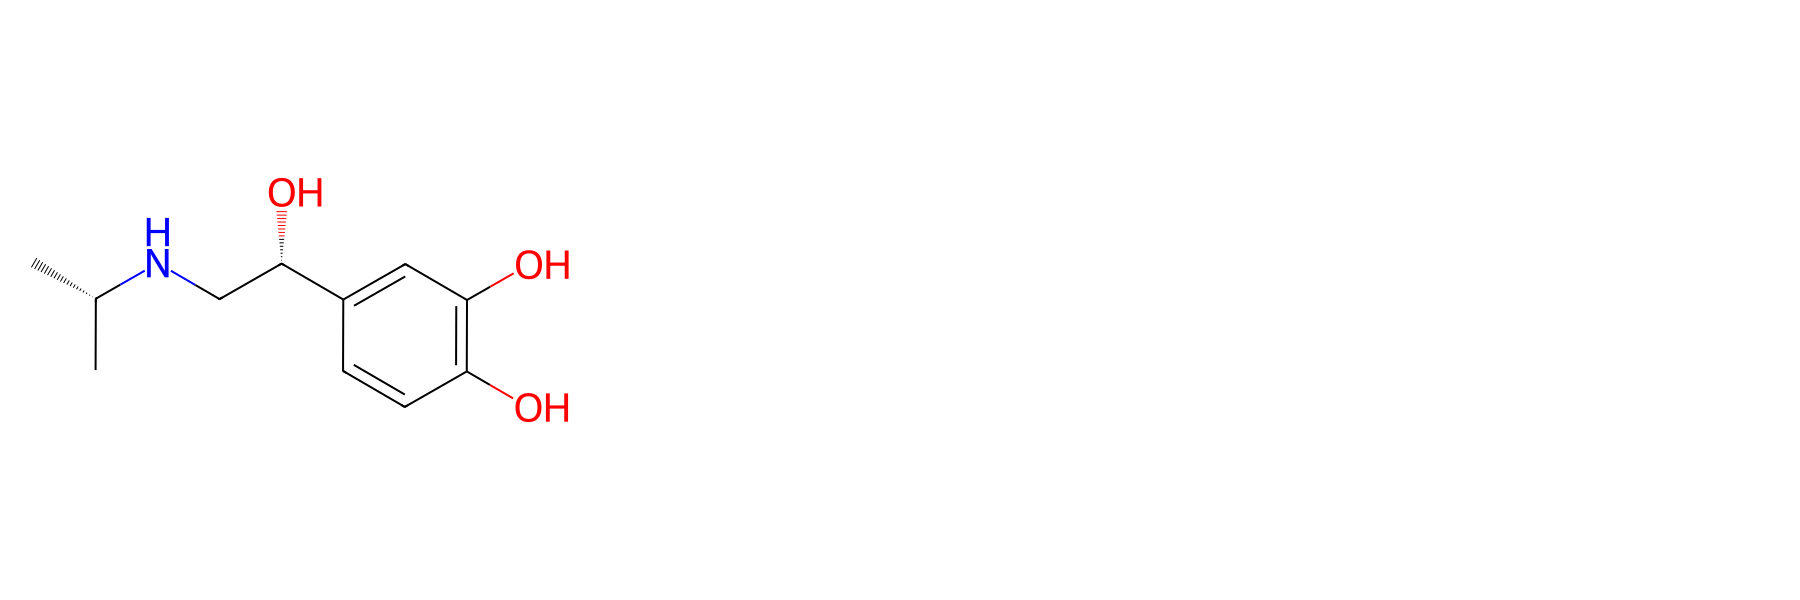

06/17/2025 12:13:31//Saved prepared ligand to /home/dcooper/projects/B2A/ligands/isoproterenol.pdb /home/dcooper/projects/B2A/ligands/isoproterenol.sdf


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [13]:
# Ligand Input
small_molecule_params = True # Change as needed
sanitize = True # Change as needed
removeHs = True # Change as needed
proximityBonding = False # Change as needed
nstd_resids = None # Change as needed
pH = 7.0 # Change as needed
neutral_Cterm = False # Change as needed

# Update params
BP.input_params['Ligand']['small_molecule_params'] = small_molecule_params
BP.input_params['Ligand']['sanitize'] = sanitize
BP.input_params['Ligand']['removeHs'] = removeHs
BP.input_params['Ligand']['proximityBonding'] = proximityBonding
BP.input_params['Ligand']['nstd_resids'] = nstd_resids
BP.input_params['Ligand']['pH'] = pH
BP.input_params['Ligand']['neutral_Cterm'] = neutral_Cterm

# Prepare
BP.ligand_prep()

# Visualizes ligand sdf and pdb
view = py3Dmol.view()
view.setBackgroundColor('white')
if hasattr(BP, 'lig_sdf'):
    view.addModel(open(BP.lig_sdf, 'r').read(),'sdf')
else:
    view.addModel(open(BP.lig_pdb, 'r').read(),'pdb')
view.setStyle({'model':0}, {'stick': {'colorscheme':'cyanCarbon'}})
view.zoomTo()
view.show()


6. **Build the forcefields**


In [14]:
BP.generate_systems()

06/17/2025 12:13:31//Created systems directory: /home/dcooper/projects/B2A/systems
06/17/2025 12:13:31//Building parameters for isoproterenol
06/17/2025 12:13:32//Protein parameters built.
06/17/2025 12:13:53//Ligand parameters built.
06/17/2025 12:13:53//System parameters built.
06/17/2025 12:13:54//Initial structure potential energy: -84446.78


**Save your input_parameters to a .json file**
- *json_fn*: str path to .json file where you would like to save your input parameters

In [15]:
# Change ligand smiles back
BP.input_params['Ligand']['smiles'] = lig_smiles

# Set .json location
json_fn = os.path.join(input_dir, 'json', f'{name}.json')
write_json(BP.input_params, json_fn)

print('WROTE:', json_fn)
print('TOOK:', datetime.now() - start)

WROTE: /home/dcooper/projects/B2A/json/isoproterenol.json
TOOK: 0:03:37.048419
